In [13]:
import os
from tqdm import tqdm 
import re

AUDIO_ROOT = './birdclef-2025/train_audio'

def natural_key(s):
    return [int(text) if text.isdigit() else text.lower() for text in re.split(r'(\d+)', s)]


species_list = sorted(
    [d for d in os.listdir(AUDIO_ROOT) if os.path.isdir(os.path.join(AUDIO_ROOT, d))],
    key=natural_key
)

# 라벨 딕셔너리
label_dict = {}
for species in sorted(os.listdir(AUDIO_ROOT)):
    species_path = os.path.join(AUDIO_ROOT, species)
    if not os.path.isdir(species_path):
        continue
    # 실제 .ogg 파일이 있는 폴더만 라벨로 사용
    files = [f for f in os.listdir(species_path)]
    if files:  # ogg 있는 폴더만
        label_dict[species] = len(label_dict)


print(label_dict)


{'1139490': 0, '1192948': 1, '1194042': 2, '126247': 3, '1346504': 4, '134933': 5, '135045': 6, '1462711': 7, '1462737': 8, '1564122': 9, '21038': 10, '21116': 11, '21211': 12, '22333': 13, '22973': 14, '22976': 15, '24272': 16, '24292': 17, '24322': 18, '41663': 19, '41778': 20, '41970': 21, '42007': 22, '42087': 23, '42113': 24, '46010': 25, '47067': 26, '476537': 27, '476538': 28, '48124': 29, '50186': 30, '517119': 31, '523060': 32, '528041': 33, '52884': 34, '548639': 35, '555086': 36, '555142': 37, '566513': 38, '64862': 39, '65336': 40, '65344': 41, '65349': 42, '65373': 43, '65419': 44, '65448': 45, '65547': 46, '65962': 47, '66016': 48, '66531': 49, '66578': 50, '66893': 51, '67082': 52, '67252': 53, '714022': 54, '715170': 55, '787625': 56, '81930': 57, '868458': 58, '963335': 59, 'amakin1': 60, 'amekes': 61, 'ampkin1': 62, 'anhing': 63, 'babwar': 64, 'bafibi1': 65, 'banana': 66, 'baymac': 67, 'bbwduc': 68, 'bicwre1': 69, 'bkcdon': 70, 'bkmtou1': 71, 'blbgra1': 72, 'blbwre1':

In [14]:
import torch
import torchaudio
import torchaudio.transforms as T
from torchvision.models import vit_b_16
from torchvision.transforms import Resize, ToTensor, Normalize, Compose
from torch.utils.data import Dataset, DataLoader
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

class AudioToSpec:
    def __init__(self, sample_rate=16000):
        self.mel = T.MelSpectrogram(sample_rate=sample_rate, n_fft=1024, hop_length=512, n_mels=224)
        self.db = T.AmplitudeToDB()
        self.transforms = Compose([
            Resize((224, 224)),  # ViT 입력 사이즈
            ToTensor(),
            Normalize(mean=[0.5], std=[0.5])
        ])

    def __call__(self, path):
        wav, sr = torchaudio.load(path)
        if wav.shape[0] > 1:
            wav = wav.mean(0, keepdim=True)  # mono 변환
        spec = self.db(self.mel(wav))
        spec = spec.squeeze(0).numpy()
        img = Image.fromarray(spec).convert('L')
        img = self.transforms(img)
        return img.repeat(3, 1, 1)  # [1,H,W] → [3,H,W]로 ViT 맞춤
        

class AudioSpecDataset(Dataset):
    def __init__(self, audio_dir, labels_dict, transform):
        self.audio_dir = audio_dir
        self.labels_dict = labels_dict
        self.transform = transform
        self.file_list = []
        for label_folder in os.listdir(audio_dir):
            full_folder_path = os.path.join(audio_dir, label_folder)
            if os.path.isdir(full_folder_path) and label_folder in labels_dict:
                for f in os.listdir(full_folder_path):
                    if f.endswith(".ogg"):
                        self.file_list.append((os.path.join(full_folder_path, f), label_folder))



    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        path, label_name = self.file_list[idx]
        label = self.labels_dict[label_name]
        spec_img = self.transform(path)
        return spec_img, label



def get_vit_model(num_classes):
    model = vit_b_16(pretrained=True)
    model.heads.head = torch.nn.Linear(model.heads.head.in_features, num_classes)
    return model

def validate(model, dataloader, device, criterion):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            out = model(X)
            loss = criterion(out, y)
            val_loss += loss.item()

            preds = out.argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)

    avg_loss = val_loss / len(dataloader)
    accuracy = correct / total
    return avg_loss, accuracy



def train(model, train_loader, val_loader, device, epoch, save_dir="./checkpoints"):
    os.makedirs(save_dir, exist_ok=True)

    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = torch.nn.CrossEntropyLoss()
    model.train()

    train_losses = []
    val_losses = []
    val_accuracies = []

    # 그래프 설정
    plt.ion()
    fig, ax = plt.subplots()
    train_line, = ax.plot([], [], label="Train Loss", marker='o')
    val_line, = ax.plot([], [], label="Val Loss", marker='x')
    ax.set_title("Loss per Epoch")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")
    ax.grid(True)
    ax.legend()

    for ep in range(epoch):
        loop = tqdm(train_loader, desc=f"[Epoch {ep+1}/{epoch}]", leave=False)
        running_loss = 0.0

        model.train()
        for X, y in loop:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(X)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            loop.set_postfix(loss=loss.item())

        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # 🔥 validation loss + acc 계산
        avg_val_loss, val_acc = validate(model, val_loader, device, criterion)
        val_losses.append(avg_val_loss)
        val_accuracies.append(val_acc)

        print(f"[Epoch {ep+1}] Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.2%}")

        # 🔥 모델 저장
        ckpt_path = os.path.join(save_dir, f"epoch_{ep+1}_train_{avg_train_loss:.4f}_val_{avg_val_loss:.4f}_acc_{val_acc:.2%}.pth")
        torch.save(model.state_dict(), ckpt_path)

        # 📈 그래프 업데이트
        train_line.set_data(range(1, ep + 2), train_losses)
        val_line.set_data(range(1, ep + 2), val_losses)
        ax.relim()
        ax.autoscale_view()
        plt.draw()
        plt.pause(0.01)

    plt.ioff()
    plt.show()


from torch.utils.data import Subset
import random

def train_val_split_dataset(dataset, val_ratio=0.2, seed=42):
    total_size = len(dataset)
    indices = list(range(total_size))
    random.seed(seed)
    random.shuffle(indices)

    val_size = int(total_size * val_ratio)
    val_indices = indices[:val_size]
    train_indices = indices[val_size:]

    train_subset = Subset(dataset, train_indices)
    val_subset = Subset(dataset, val_indices)
    return train_subset, val_subset



{'1139490': 0, '1192948': 1, '1194042': 2, '126247': 3, '1346504': 4, '134933': 5, '135045': 6, '1462711': 7, '1462737': 8, '1564122': 9, '21038': 10, '21116': 11, '21211': 12, '22333': 13, '22973': 14, '22976': 15, '24272': 16, '24292': 17, '24322': 18, '41663': 19, '41778': 20, '41970': 21, '42007': 22, '42087': 23, '42113': 24, '46010': 25, '47067': 26, '476537': 27, '476538': 28, '48124': 29, '50186': 30, '517119': 31, '523060': 32, '528041': 33, '52884': 34, '548639': 35, '555086': 36, '555142': 37, '566513': 38, '64862': 39, '65336': 40, '65344': 41, '65349': 42, '65373': 43, '65419': 44, '65448': 45, '65547': 46, '65962': 47, '66016': 48, '66531': 49, '66578': 50, '66893': 51, '67082': 52, '67252': 53, '714022': 54, '715170': 55, '787625': 56, '81930': 57, '868458': 58, '963335': 59, 'amakin1': 60, 'amekes': 61, 'ampkin1': 62, 'anhing': 63, 'babwar': 64, 'bafibi1': 65, 'banana': 66, 'baymac': 67, 'bbwduc': 68, 'bicwre1': 69, 'bkcdon': 70, 'bkmtou1': 71, 'blbgra1': 72, 'blbwre1':

[Epoch 1] Train Loss: 4.7988 | Val Loss: 4.7762 | Val Acc: 2.47%


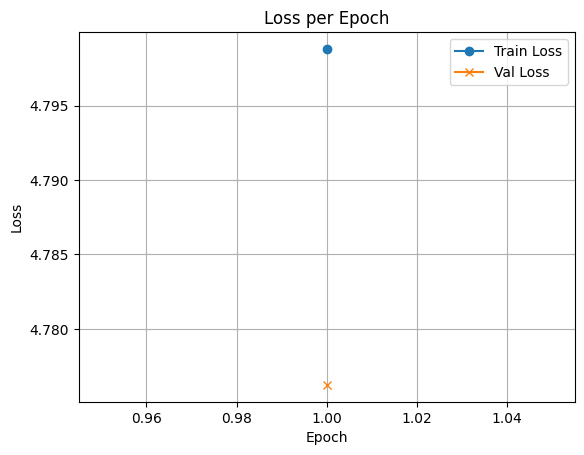

[Epoch 2] Train Loss: 4.7509 | Val Loss: 4.7612 | Val Acc: 3.66%


<Figure size 640x480 with 0 Axes>

[Epoch 3] Train Loss: 4.7454 | Val Loss: 4.7582 | Val Acc: 3.66%


<Figure size 640x480 with 0 Axes>

[Epoch 4] Train Loss: 4.7439 | Val Loss: 4.7617 | Val Acc: 3.66%


<Figure size 640x480 with 0 Axes>

[Epoch 5] Train Loss: 4.7413 | Val Loss: 4.7569 | Val Acc: 3.66%


<Figure size 640x480 with 0 Axes>

[Epoch 6] Train Loss: 4.7390 | Val Loss: 4.7605 | Val Acc: 3.66%


<Figure size 640x480 with 0 Axes>

[Epoch 7] Train Loss: 4.7372 | Val Loss: 4.7585 | Val Acc: 3.66%


<Figure size 640x480 with 0 Axes>

[Epoch 8] Train Loss: 4.7355 | Val Loss: 4.7502 | Val Acc: 3.66%


<Figure size 640x480 with 0 Axes>

[Epoch 9] Train Loss: 4.7345 | Val Loss: 4.7494 | Val Acc: 3.66%


<Figure size 640x480 with 0 Axes>

[Epoch 10] Train Loss: 4.7334 | Val Loss: 4.7534 | Val Acc: 3.66%


<Figure size 640x480 with 0 Axes>

[Epoch 11] Train Loss: 4.7324 | Val Loss: 4.7451 | Val Acc: 2.47%


<Figure size 640x480 with 0 Axes>

[Epoch 12] Train Loss: 4.7315 | Val Loss: 4.7492 | Val Acc: 3.66%


<Figure size 640x480 with 0 Axes>

[Epoch 13] Train Loss: 4.7307 | Val Loss: 4.7507 | Val Acc: 3.66%


<Figure size 640x480 with 0 Axes>

[Epoch 14] Train Loss: 4.7299 | Val Loss: 4.7483 | Val Acc: 3.66%


<Figure size 640x480 with 0 Axes>

[Epoch 15] Train Loss: 4.7294 | Val Loss: 4.7521 | Val Acc: 3.66%


<Figure size 640x480 with 0 Axes>

[Epoch 16] Train Loss: 4.7297 | Val Loss: 4.7456 | Val Acc: 3.66%


<Figure size 640x480 with 0 Axes>

[Epoch 17] Train Loss: 4.7290 | Val Loss: 4.7463 | Val Acc: 3.66%


<Figure size 640x480 with 0 Axes>

[Epoch 18] Train Loss: 4.7289 | Val Loss: 4.7478 | Val Acc: 3.66%


<Figure size 640x480 with 0 Axes>

[Epoch 19] Train Loss: 4.7649 | Val Loss: 4.7481 | Val Acc: 3.66%


<Figure size 640x480 with 0 Axes>

[Epoch 20] Train Loss: 4.7301 | Val Loss: 4.7449 | Val Acc: 3.66%


<Figure size 640x480 with 0 Axes>

[Epoch 21] Train Loss: 4.7286 | Val Loss: 4.7521 | Val Acc: 3.66%


<Figure size 640x480 with 0 Axes>

[Epoch 22] Train Loss: 4.7282 | Val Loss: 4.7471 | Val Acc: 3.66%


<Figure size 640x480 with 0 Axes>

[Epoch 23] Train Loss: 4.7277 | Val Loss: 4.7449 | Val Acc: 2.71%


<Figure size 640x480 with 0 Axes>

[Epoch 24] Train Loss: 4.7263 | Val Loss: 4.7512 | Val Acc: 3.66%


<Figure size 640x480 with 0 Axes>

[Epoch 25] Train Loss: 4.7265 | Val Loss: 4.7487 | Val Acc: 3.66%


<Figure size 640x480 with 0 Axes>

[Epoch 26] Train Loss: 4.7277 | Val Loss: 4.7464 | Val Acc: 3.66%


<Figure size 640x480 with 0 Axes>

[Epoch 27] Train Loss: 4.7265 | Val Loss: 4.7480 | Val Acc: 3.66%


<Figure size 640x480 with 0 Axes>

[Epoch 28] Train Loss: 4.7268 | Val Loss: 4.7467 | Val Acc: 3.66%


<Figure size 640x480 with 0 Axes>

[Epoch 29] Train Loss: 4.7258 | Val Loss: 4.7481 | Val Acc: 3.66%


<Figure size 640x480 with 0 Axes>

[Epoch 30] Train Loss: 4.7269 | Val Loss: 4.7462 | Val Acc: 3.66%


<Figure size 640x480 with 0 Axes>

[Epoch 31] Train Loss: 4.7263 | Val Loss: 4.7464 | Val Acc: 3.66%


<Figure size 640x480 with 0 Axes>

[Epoch 32] Train Loss: 4.7263 | Val Loss: 4.7489 | Val Acc: 3.66%


<Figure size 640x480 with 0 Axes>

[Epoch 33] Train Loss: 4.7264 | Val Loss: 4.7469 | Val Acc: 3.66%


<Figure size 640x480 with 0 Axes>

KeyboardInterrupt: 

In [ ]:
labels_dict = {f: label_dict[f] for f in os.listdir("./birdclef-2025/train_audio/")}

print(labels_dict)
transform = AudioToSpec()

full_dataset = AudioSpecDataset(audio_dir="./birdclef-2025/train_audio", labels_dict=label_dict, transform=transform)

train_dataset, val_dataset = train_val_split_dataset(full_dataset, val_ratio=0.2)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


model = get_vit_model(num_classes=len(label_dict))

train(
    model,
    train_loader=train_loader,
    val_loader=val_loader,
    device="cuda" if torch.cuda.is_available() else "cpu",
    epoch=100,
    save_dir="./vit_checkpoints"
)

